# Reversible Network Reconnection Model

Attempt at implementing the RNR model as described in Okuda et al. 2012:

>_Reversible network reconnection model for simulating large deformation in dynamic tissue morphogenesis_, Satoru Okuda, Yasuhiro Inoue, Mototsugu Eiraku, Yoshiki Sasai and Taiji Adachi Biomech Model Mechanobiol (2013) 12:627–644 [DOI 10.1007/s10237-012-0430-7](http://link.springer.com/article/10.1007%2Fs10237-012-0430-7)


The authors give 4 conditions which we detail and implement bellow.




## Condition 1 - Center of a face

The center of a face is defined by the average position of the face's edges midpoints, weighted by their lengths.

$$ \mathbf{r}_{\alpha} = \frac{\sum_{ij\alpha}\ell_{ij} (\mathbf{r}_i + \mathbf{r}_j)/2}{\sum_{ij\alpha}\ell_{ij}}$$


In [1]:
import numpy as np, pandas as pd
import ipyvolume as ipv
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Epithelium
from tyssue import BulkGeometry, RNRGeometry
from tyssue import Sheet
from tyssue.config.geometry import bulk_spec
from tyssue.generation import three_faces_sheet
from tyssue.generation import extrude
from tyssue.draw import sheet_view, highlight_cells

from tyssue.topology.bulk_topology import IH_transition, HI_transition



draw_spec = {'face': {'visible': True}}




sheet = Sheet.planar_sheet_3d('sheet', 5, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')

eptm = Epithelium('20faces_3D', datasets, bulk_spec())
RNRGeometry.update_all(eptm)
RNRGeometry.center(eptm)
RNRGeometry.update_all(eptm)


eptm.settings['threshold_length'] = 1e-4
print(eptm.Nf, eptm.Ne, eptm.Nv)
draw_spec['face']['color'] = eptm.face_df.area
draw_spec['face']['color_range'] = (0, 1)

ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

93 414 70


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

## I→H transition

![IH transition in a bulk and a RNR](../data/png/IH_transition.png)



In [2]:
e_1011 = 26
eptm.settings['threshold_length'] = 0.5

srce, trgt, face, cell = eptm.edge_df.loc[e_1011,
                                          ['srce', 'trgt',
                                           'face', 'cell']]

IH_transition(eptm, e_1011)
RNRGeometry.update_all(eptm)

highlight_cells(eptm, cell, reset_visible=True)
draw_spec['face']['color'] = eptm.face_df.area


ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

# H → I transition

In [3]:
fa = 93


HI_transition(eptm, fa)
RNRGeometry.update_all(eptm)

highlight_cells(eptm, cell, reset_visible=False)
ipv.clear()
draw_spec['face']['color'] = eptm.face_df.area

fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

### Testing for I→H / H →I transition triggers

In [4]:
#eptm.settings['threshold_length'] = 1e-3
eptm.settings['threshold_length'] = eptm.edge_df.length.min()+1e-3

In [5]:
def find_rearangements(eptm):
    l_th = eptm.settings['threshold_length']
    up_num_sides = eptm.upcast_face(eptm.face_df['num_sides'])   
    shorts = eptm.edge_df[eptm.edge_df['length'] < l_th]
    non_triangular = up_num_sides[up_num_sides > 4 ].index
    edges_IH = set(shorts.index).intersection(non_triangular)

    max_f_length = shorts.groupby('face')['length'].apply(max)
    short_faces = max_f_length[max_f_length < l_th].index
    three_faces = eptm.face_df[eptm.face_df['num_sides'] == 3].index
    faces_HI = set(three_faces).intersection(short_faces)
    return edges_IH, faces_HI

find_rearangements(eptm)

({410, 412}, set())

### Condition 3

This condition is satisfied if `eptm.settings['threshold_length']`
is well defined, i.e, small with respect to the unit length or the
average edge length.

### Condition 4

* (i)  Two edges never share two vertices simultaneously.

_In our half-edge architecture, this is not as straight forward. But I think the condition can
be reformulated as:_ Two edges **from the same face** never share two edges simultanously.
I don't know how to demonstrate this, but I think these are equivalent (to get two edges together, you need to "squeeze" one face between those two.

* (ii) Two polygonal faces never share two or more edges simultaneously.


In [6]:
from tyssue.topology.base_topology import condition_4i, condition_4ii

In [7]:
condition_4i(eptm), condition_4ii(eptm)

(Int64Index([], dtype='int64', name='face'), [])

In [8]:
eptm.settings['threshold_length'] = 0.5

IH_transition(eptm, eptm.edge_df.index[-1])
RNRGeometry.update_all(eptm)
draw_spec['face']['color'] = eptm.face_df.area

ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…

In [9]:
eptm.validate()

True

In [10]:
bad_edges = eptm.edge_df[~eptm.edge_df['is_valid']].index

In [11]:
bad_edges

Int64Index([], dtype='int64', name='edge')

In [12]:
invalid = eptm.get_invalid()
assert np.alltrue(1 - invalid)
assert np.alltrue(eptm.edge_df['sub_vol'] > 0)

In [10]:
%pdb

Automatic pdb calling has been turned ON


## Mechanical model & computation of friction coefficient

From the paper _Vertex dynamics simulations of viscosity-dependent deformation during tissue morphogenesis_, S. Okuda et al. Biomech Model Mechanobiol, 2014, [DOI 10.1007/s10237-014-0613-5](https://doi.org/10.1007/s10237-014-0613-5)

$$
\eta_i\left(\frac{d\mathbf{r}_i}{dt} - \mathbf{v}_i\right) = -\nabla_i U
$$

$$
\eta_i = \sum^{\mathrm{element}} \eta_e
$$



In [4]:
s_25 = eptm.edge_df[eptm.edge_df['srce']==25]

In [5]:
for dset in eptm.datasets.values():
    dset['viscosity'] = 1.

In [42]:
def update_viscosity():
    eptm.edge_df['cv'] = eptm.upcast_cell(eptm.cell_df['viscosity'])
    eptm.vert_df['visosity'] = eptm.edge_df.groupby('srce')['cv'].sum().values()
    

In [6]:
for c in sheet.coords:
    eptm.vert_df['v'+c] = 0

In [7]:
from scipy import sparse

In [31]:
square_v = (eptm.Nv, eptm.Nv)
edge_connect = sparse.coo_matrix(
    (np.ones(eptm.Ne),
     (eptm.edge_df['srce'], eptm.edge_df['trgt'])),
    shape=square_v
)



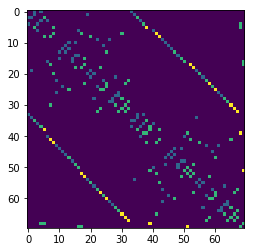

In [32]:
plt.imshow(edge_connect.toarray())

In [49]:
def _connect(df):
    idx_i, idx_j = np.meshgrid(df['srce'], df['trgt'])
    return pd.DataFrame(
        {"row": idx_i.ravel(),
         "col": idx_j.ravel()})

def _make_coo(connect_, shape):
    mat = sparse.coo_matrix(
        (
            np.ones(connect_.shape[0]),
            (
                connect_['row'],
                connect_['col']
            )
        ),
        shape=shape
    )
    return mat

In [50]:
face_connect = _make_coo(
    eptm.edge_df.groupby("face").apply(_connect), square_v
)

cell_connect = _make_coo(
    eptm.edge_df.groupby("cell").apply(_connect), square_v
)

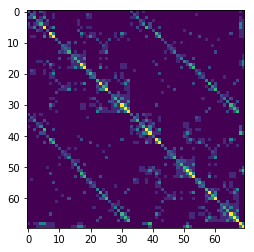

In [51]:
plt.imshow(face_connect.toarray())

In [52]:
edge_connect + face_connect + cell_connect

<70x70 sparse matrix of type '<class 'numpy.float64'>'
	with 1276 stored elements in Compressed Sparse Row format>

In [53]:
70 * 70

4900

In [54]:
edge_connect.max()

3.0

In [55]:
face_connect.max()

9.0

In [ ]:
vérif facture SATTSE